## Machine Learning project to analyse jobs related scraped data from Seek.com.au

### Executive Summary

### This project is a Machine Learning project which analyses job postings online using a variety of technologies described below to understand two important questions: which factors are important in predicting the salary range associated with a particular job, and which factors are important in predicting the job title ( data science vs other data jobs) associated with a particular job posted online. For purposes of this project, the jobs were collected from Seek.com.au. Data Analytics and Data Science related jobs were collected from this website to form the database for this project. Beautiful Soup was a technology used to scrape information associated with each job, such as the job title, city, exact area within that city, salary range associated with a job, work type ( full/part time or casual roles), industry the role is in, advertiser information, job description etc. Four datasets were collected initially, one for each of data scientist, data analyst, research scientist, business intelligence analyst. Once these datasets were populated, then they were combined into one dataset which was the main database used for analysing and developing machine learning models on. 

### For the first question which was understanding factors in predicting salary range, I labelled the salary range of 120000-150000 as 1 (high) and 50000-80000, 80000-120000 as 0 (low). Once the labels were established, I went on to clean the dataset and transform them for feeding into the machine learning models. To start with, I dropped one column ‘Unnamed: 0’ which did not contain any useful information. Then, I dropped few rows which had null values in the important columns such as ‘JD’, ‘Job Description’ and ‘Strong Words’. I also dropped the ‘Salary’ column as it mostly contained null values which could not be used in any modelling process. Once the data was relatively clean, I split the dataset into a feature design matrix which had all the predictors used in the model and the target variable which was our salary class and this was what the model will be predicting for unseen test data. To make the feature data frame usable, I dummy encoded few features such as Area, Work Type, Classification and Salary Type. Dummy Encoding is a process where by each value within a column becomes a column of it’s own and depending on whether a data point has this value, it receives a 0 or 1 for that data point and this way new features are created which have greater impact on the models which I will be using later on. Then I use Natural Language Processing, specifically two types of vectorizers which as Count vectorizer which counts the frequency of occurrence of a word within a cell and Tf-idf vectorizer which penalizes words which are common across most documents and increases the importance of rare words across documents. Once these transformations are performed, a Logistic Regression and Decision Tree model are fit on the count vectorized data. These models perform poorer than the baseline model which is the proportion of the majority class in the salary class column. Since the number of columns have significantly increased in proportion to the actual data frame, I used a technique called Principal Component Analysis (PCA). This was helpful in reducing the number of columns in my feature matrix significantly while still being able to account for more than 90% of the variance in the information contained in my feature matrix. Once the PCA was implemented, the same models were refit on the new reduced data frame which significantly increased the model performance than the baseline accuracy I set earlier. To see how the Tf-idf vectorized data frame performed with the models, I refit the above models on this data and observed that the models performed best in this case. Incorporating PCA along with Tf-Idf vectorization yielded a marginal improvement in the model performance from 70.12% to 70.14%. The features in this case which seemed to have the most importance in predicting the salary class were words such as Research, Senior, Excel, Agile, Communication, Lead, Stakeholders which indicates that having more of these skills would indicate that the role was more of a senior position which would command a higher salary. 

### For the second question, the data frame was transformed to create a new column where data points which had the words Data Scientist in them were labelled 1 and those which had titles other than Data Scientist were labelled 0. This then became the target variable which was to be predicted from the feature data frame. The feature data frame was transformed using Tf-Idf vectorization and dummy encoding as above and Logistic Regression and Random Forest models were fit on the feature data frame. Both the models performed better than the baseline accuracy of 85%. The terms which were of most importance here were Statistics, Python, Predictive, Scientist, Algorithms, Stakeholders, Machine, Learning, Mathematics. These are the words which I would expect to find associated with a Data Science role and not as much in other data roles such as Data Analyst or Data Engineer which are less mathematical and more programming based. 

In [1]:
# Libraries to import
import numpy as np
import pandas as pd
import missingno as msno
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline


### 1. Predicting factors that impact salary

In [2]:
# All four dataframes with the scraped jobs data
da_df = pd.read_csv('./data_analyst_jobs.csv')
ds_df = pd.read_csv('./data_scientist_jobs.csv')
rs_df = pd.read_csv('./research_scientist_jobs.csv')
bi_df = pd.read_csv('./business_intelligence_jobs.csv')

In [3]:
# Combining the dataframes into a single dataframe
jobs_df = pd.concat([da_df, ds_df, rs_df, bi_df], ignore_index=True)

In [4]:
# Exporting the dataframe to a csv file
jobs_df.to_csv('all_jobs.csv')

In [5]:
# Looking at the dataframe head
jobs_df

,Unnamed: 0,Salary Range,Link,Title,Listing Date,Expiry Date,Job Title,Job Teaser,Advertiser,Area,Work Type,Classification,Salary,Salary Type,JD,Location,Job Description,Strong Words
0,0,50000-80000,https://www.seek.com.au/job/40066081,Business Analyst - Digital/Data projects,2019-10-01T03:39:07.000Z,2019-10-31T03:39:07.000Z,Business Analyst - Digital/Data projects,We are looking for a passionate Business Analy...,Chandler,"CBD, Inner West & Eastern Suburbs",Full Time,Information & Communication Technology,NaN,AnnualPackage,"<div class=""_2e4Pi2B"" data-automation=""mobileT...",Sydney,Business Analyst Would you like to work in on...,"['Business Analyst', ""Australia's fastest grow..."
1,1,50000-80000,https://www.seek.com.au/job/40175039,Business Analyst,2019-10-16T00:55:56.000Z,2019-11-15T00:55:55.000Z,Business Analyst,Multiple permanent and contract positions avai...,Citi,"CBD, Inner West & Eastern Suburbs",Full Time,Banking & Financial Services,Competitive salary + bonus + gym onsite,AnnualPackage,"<div class=""_2e4Pi2B"" data-automation=""mobileT...",Sydney,"Accountable to the Head of Analysis, Solutions...","['KEY ACCOUNTABILITIES', 'KEY COMPETENCIES / S..."
2,2,50000-80000,https://www.seek.com.au/job/40273309,Data Analyst,2019-10-29T20:51:34.000Z,2019-11-29T12:59:59.000Z,Data Analyst,Be part of a team to establish a new retail an...,Woolworth Liquor Group,NaN,Full Time,Information & Communication Technology,Your pathway to multiple career opportunities,AnnualPackage,"<div class=""_2e4Pi2B"" data-automation=""mobileT...",Sydney,About Us The Endeavour Drinks Group ambition...,"['About Us', 'The Role', 'Key responsibilities..."
3,3,50000-80000,https://www.seek.com.au/job/40268641,Data Analyst,2019-10-29T03:15:38.000Z,2019-11-28T12:59:59.000Z,Data Analyst,Immediate Start - Full time permanent Data Ana...,Beaumont People,"CBD, Inner West & Eastern Suburbs",Full Time,Information & Communication Technology,NaN,AnnualPackage,"<div class=""_2e4Pi2B"" data-automation=""mobileT...",Sydney,...,"['Data Analyst', 'Immediate start – full-time ..."
4,4,50000-80000,https://www.seek.com.au/job/40240317,Junior Data Analyst- Management Consultancy,2019-10-24T05:57:10.000Z,2019-11-23T05:57:09.000Z,Junior Data Analyst- Management Consultancy,Are you a junior market researcher/analyst tha...,Resources Group,"CBD, Inner West & Eastern Suburbs",Full Time,Marketing & Communications,"$50,000 - $60,000 + super",AnnualPackage,"<div class=""_2e4Pi2B"" data-automation=""mobileT...",Sydney,Are you a junior market researcher/analyst tha...,['Sitting in the quantitative team you will be...
5,5,50000-80000,https://www.seek.com.au/job/40267706,Junior Data Analytics Consultants - Data Foren...,2019-10-29T02:15:53.000Z,2019-11-28T12:59:59.000Z,Junior Data Analytics Consultants - Data Foren...,Correlate Resources: Your trusted Data Analyti...,Correlate Resources,"CBD, Inner West & Eastern Suburbs",Full Time,Banking & Financial Services,$75-90k + Super + Bonus,AnnualPackage,"<div class=""_2e4Pi2B"" data-automation=""mobileT...",Sydney,"Our client is a high profile, market leading, ...",[]
6,6,50000-80000,https://www.seek.com.au/job/40002236,Start your new career as a Data Analyst,2019-10-22T22:41:33.000Z,2019-11-22T01:53:13.000Z,Start your new career as a Data Analyst,Start your career as a consultant data analyst...,The Data School Pty Ltd,"CBD, Inner West & Eastern Suburbs",Full Time,Information & Communication Technology,"$55,000 - $59,999",AnnualPackage,"<div class=""_2e4Pi2B"" data-automation=""mobileT...",Sydney,Data is exploding The demand for great data an...,"['Data is exploding', 'data analysts', 'data s..."
7,7,50000-80000,https://www.seek.com.au/job/40247378,Business Data Analyst (monitoring and evaluation),2019-10-25T03:13:02.000Z,2019-11-24T12:59:59.000Z,Business Data Analyst (monitoring and evaluation),Business Data Analyst - monitoring and evaluat...,Modis,"CBD, Inner West & Eastern Suburbs",Contract/Temp,Information & Communication Technology,N

In [6]:
# Shape of the dataframe
jobs_df.shape

(4384, 18)

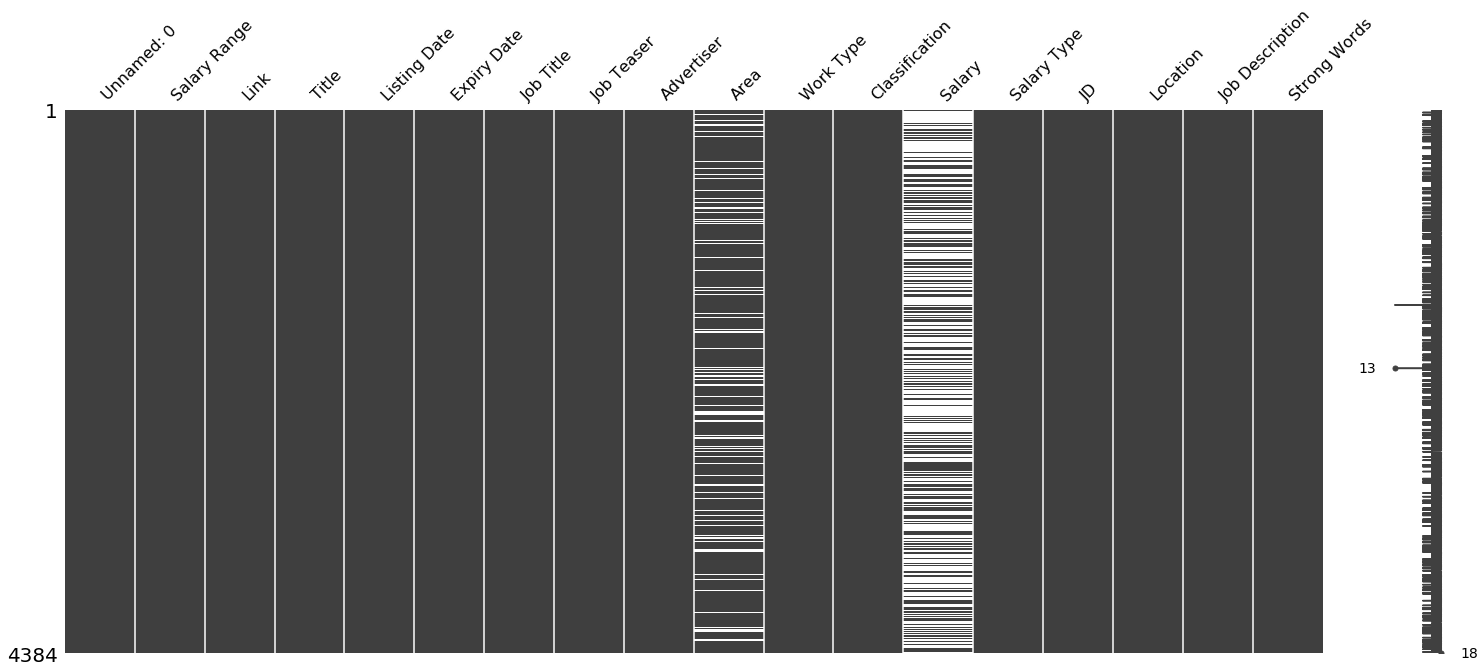

In [7]:
# Checking for column density in the jobs dataframe
msno.matrix(jobs_df)

In [8]:
# Checking data types of column names
jobs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4384 entries, 0 to 4383
Data columns (total 18 columns):
Unnamed: 0         4384 non-null int64
Salary Range       4384 non-null object
Link               4384 non-null object
Title              4384 non-null object
Listing Date       4384 non-null object
Expiry Date        4384 non-null object
Job Title          4384 non-null object
Job Teaser         4384 non-null object
Advertiser         4384 non-null object
Area               3739 non-null object
Work Type          4384 non-null object
Classification     4384 non-null object
Salary             1790 non-null object
Salary Type        4384 non-null object
JD                 4382 non-null object
Location           4384 non-null object
Job Description    4382 non-null object
Strong Words       4382 non-null object
dtypes: int64(1), object(17)
memory usage: 616.6+ KB


In [9]:
# Cheking how many null values are present in each feature column
jobs_df.isna().sum()

Unnamed: 0            0
Salary Range          0
Link                  0
Title                 0
Listing Date          0
Expiry Date           0
Job Title             0
Job Teaser            0
Advertiser            0
Area                645
Work Type             0
Classification        0
Salary             2594
Salary Type           0
JD                    2
Location              0
Job Description       2
Strong Words          2
dtype: int64

In [10]:
# Dropping the 'Unnamed: 0' feature as it does not contain any useful information
jobs_df.drop('Unnamed: 0', axis=1, inplace=True)

In [11]:
# Dropping few rows based on NA values in certain columns
jobs_df = jobs_df.dropna(subset = ['JD', 'Job Description', 'Strong Words'])

In [12]:
# Dropping the Salary Column obtained from scraping as they mostly contain null values
jobs_df.drop('Salary', axis=1, inplace=True)

D:\Softwares\Anaconda\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [13]:
# Checking the dataframe shape after some cleaning
jobs_df.shape

(4382, 16)

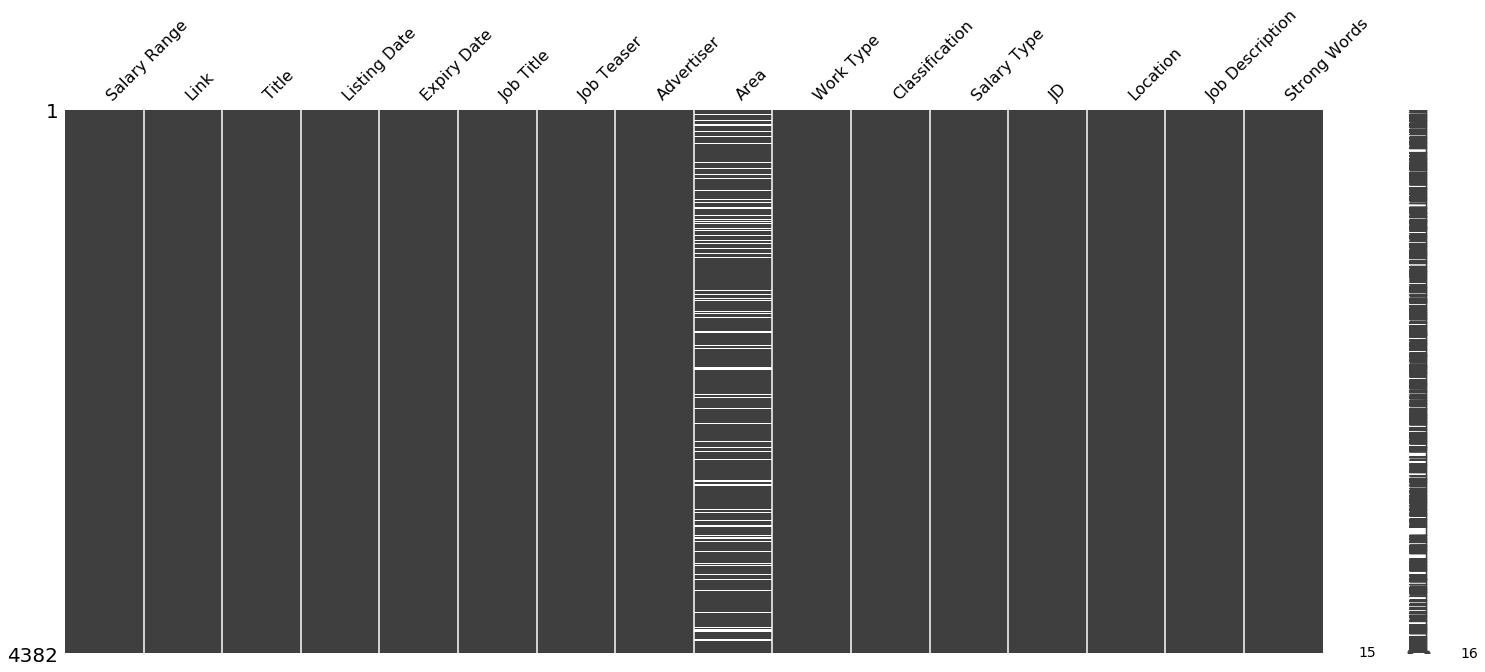

In [14]:
# Checking for column density in the jobs dataframe
msno.matrix(jobs_df)

In [15]:
jobs_df['Salary Range'].value_counts()

80000-120000     1772
120000-150000    1384
50000-80000      1226
Name: Salary Range, dtype: int64

In [16]:
# Mapping the salary ranges to a binary target variable 'Salary'
jobs_df['Salary'] = jobs_df['Salary Range'].map({'50000-80000': 0, '80000-120000': 0, '120000-150000': 1})

D:\Softwares\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [17]:
# Checking the different job titles available in the dataframe and cleaning them
print(jobs_df['Title'].value_counts())

Business Analyst                                                             137
Data Analyst                                                                  93
Data Scientist                                                                75
Data Engineer                                                                 46
Commercial Analyst                                                            42
Senior Business Analyst                                                       40
Actuarial Analyst                                                             32
Technical Business Analyst                                                    31
Senior Data Analyst                                                           28
Financial Analyst                                                             27
Senior Analyst x2 (Actuarial/Pricing) | Data/ Analytics | Sydney location     24
BI Developer                                                                  22
Big Data Engineer           

In [18]:
# Converting the job titles to lower case for easy searching and slicing of dataframe
jobs_df['Title'] = jobs_df['Title'].str.lower()

D:\Softwares\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [19]:
# Copying jobs dataframe to use in the second question
jobs1_df = jobs_df.copy()

In [20]:
# Subsetting the dataframe to only include certain job titles
jobs_df = jobs_df[jobs_df['Title'].str.contains('data') | jobs_df['Title'].str.contains('analyst') | jobs_df['Title'].str.contains('scientist') | jobs_df['Title'].str.contains('research') | jobs_df['Title'].str.contains('business') | jobs_df['Title'].str.contains('intelligence')] 
jobs_df = jobs_df.reset_index(drop=True)
jobs_df

,Salary Range,Link,Title,Listing Date,Expiry Date,Job Title,Job Teaser,Advertiser,Area,Work Type,Classification,Salary Type,JD,Location,Job Description,Strong Words,Salary
0,50000-80000,https://www.seek.com.au/job/40066081,business analyst - digital/data projects,2019-10-01T03:39:07.000Z,2019-10-31T03:39:07.000Z,Business Analyst - Digital/Data projects,We are looking for a passionate Business Analy...,Chandler,"CBD, Inner West & Eastern Suburbs",Full Time,Information & Communication Technology,AnnualPackage,"<div class=""_2e4Pi2B"" data-automation=""mobileT...",Sydney,Business Analyst Would you like to work in on...,"['Business Analyst', ""Australia's fastest grow...",0
1,50000-80000,https://www.seek.com.au/job/40175039,business analyst,2019-10-16T00:55:56.000Z,2019-11-15T00:55:55.000Z,Business Analyst,Multiple permanent and contract positions avai...,Citi,"CBD, Inner West & Eastern Suburbs",Full Time,Banking & Financial Services,AnnualPackage,"<div class=""_2e4Pi2B"" data-automation=""mobileT...",Sydney,"Accountable to the Head of Analysis, Solutions...","['KEY ACCOUNTABILITIES', 'KEY COMPETENCIES / S...",0
2,50000-80000,https://www.seek.com.au/job/40273309,data analyst,2019-10-29T20:51:34.000Z,2019-11-29T12:59:59.000Z,Data Analyst,Be part of a team to establish a new retail an...,Woolworth Liquor Group,NaN,Full Time,Information & Communication Technology,AnnualPackage,"<div class=""_2e4Pi2B"" data-automation=""mobileT...",Sydney,About Us The Endeavour Drinks Group ambition...,"['About Us', 'The Role', 'Key responsibilities...",0
3,50000-80000,https://www.seek.com.au/job/40268641,data analyst,2019-10-29T03:15:38.000Z,2019-11-28T12:59:59.000Z,Data Analyst,Immediate Start - Full time permanent Data Ana...,Beaumont People,"CBD, Inner West & Eastern Suburbs",Full Time,Information & Communication Technology,AnnualPackage,"<div class=""_2e4Pi2B"" data-automation=""mobileT...",Sydney,...,"['Data Analyst', 'Immediate start – full-time ...",0
4,50000-80000,https://www.seek.com.au/job/40240317,junior data analyst- management consultancy,2019-10-24T05:57:10.000Z,2019-11-23T05:57:09.000Z,Junior Data Analyst- Management Consultancy,Are you a junior market researcher/analyst tha...,Resources Group,"CBD, Inner West & Eastern Suburbs",Full Time,Marketing & Communications,AnnualPackage,"<div class=""_2e4Pi2B"" data-automation=""mobileT...",Sydney,Are you a junior market researcher/analyst tha...,['Sitting in the quantitative team you will be...,0
5,50000-80000,https://www.seek.com.au/job/40267706,junior data analytics consultants - data foren...,2019-10-29T02:15:53.000Z,2019-11-28T12:59:59.000Z,Junior Data Analytics Consultants - Data Foren...,Correlate Resources: Your trusted Data Analyti...,Correlate Resources,"CBD, Inner West & Eastern Suburbs",Full Time,Banking & Financial Services,AnnualPackage,"<div class=""_2e4Pi2B"" data-automation=""mobileT...",Sydney,"Our client is a high profile, market leading, ...",[],0
6,50000-80000,https://www.seek.com.au/job/40002236,start your new career as a data analyst,2019-10-22T22:41:33.000Z,2019-11-22T01:53:13.000Z,Start your new career as a Data Analyst,Start your career as a consultant data analyst...,The Data School Pty Ltd,"CBD, Inner West & Eastern Suburbs",Full Time,Information & Communication Technology,AnnualPackage,"<div class=""_2e4Pi2B"" data-automation=""mobileT...",Sydney,Data is exploding The demand for great data an...,"['Data is exploding', 'data analysts', 'data s...",0
7,50000-80000,https://www.seek.com.au/job/40247378,business data analyst (monitoring and evaluation),2019-10-25T03:13:02.000Z,2019-11-24T12:59:59.000Z,Business Data Analyst (monitoring and evaluation),Business Data Analyst - monitoring and evaluat...,Modis,"CBD, Inner West & Eastern Suburbs",Contract/Temp,Information & Communication Technology,AnnualPackage,"<div class=""_2e4Pi2B"" data-automation=""mobileT...",Sydney,Business Data Analyst (Monitoring and Evaluati...,['Business Data Analyst (Monitoring and Evalua...,0
8,

In [21]:
# Splitting the jobs dataframe to feature dataframe and target
X = jobs_df.drop('Salary', axis=1)
y = jobs_df['Salary'].values

In [22]:
# Dummification of certain features in X before train-test split
area_dummy = pd.get_dummies(X['Area'])
area_dummy.drop('Southern Suburbs & Sutherland Shire', axis=1, inplace=True)

worktype_dummy = pd.get_dummies(X['Work Type'])
worktype_dummy.drop('Casual/Vacation', axis=1, inplace=True)

classification_dummy = pd.get_dummies(X['Classification'])
classification_dummy.drop('Accounting', axis=1, inplace=True)

salarytype_dummy = pd.get_dummies(X['Salary Type'])
salarytype_dummy.drop('HourlyRate', axis=1, inplace=True)

X = pd.concat([X['Job Description'], area_dummy, worktype_dummy, classification_dummy,
             salarytype_dummy], axis=1)

X.shape

(3380, 36)

In [23]:
# Using the count vectorizer to split up the words from job descriptions as
# separate features and joining them to the original jobs dataframe
cvec = CountVectorizer(stop_words='english')
# Fitting on the training dataset
cvec.fit(X['Job Description'])
len(cvec.get_feature_names())

16968

In [24]:
# Transforming the X matrix using cvec and printing shapes of datasets
# to ensure uniformity in shapes
print(X.shape)
X1 = pd.DataFrame(cvec.transform(X['Job Description']).todense(),
                       columns=cvec.get_feature_names())
print(X1.shape)
X2 = X.drop('Job Description', axis=1)
X2 = X2.reset_index(drop=True)
print(X2.shape)
X_final = pd.concat([X2, X1], axis=1)
print(X_final.shape)

(3380, 36)
(3380, 16968)
(3380, 35)
(3380, 17003)


In [25]:
print(X_final.shape)
print(y.shape)

(3380, 17003)
(3380,)


In [26]:
# Taking a 10-fold cross validation on the logistic regression model
model = LogisticRegression()
scores = cross_val_score(model, X_final, y, cv=10, scoring='accuracy')
print('Mean cross-validated accuracy is: ', np.mean(scores))

D:\Softwares\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Softwares\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Softwares\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Softwares\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Softwares\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  

Mean cross-validated accuracy is:  0.6459528627522761


In [27]:
# Baseline accuracy is proportion of majority class in y
1 - np.mean(y)

0.6727810650887573

In [28]:
# Implementing a Decision Tree Classifier on the dataframe containing the count vectorized data
dtc_params = {
    'max_depth':[None,3,4]
}

dtc_gs = GridSearchCV(DecisionTreeClassifier(), dtc_params, cv=4, verbose=1,
                     n_jobs=-1)

dtc_gs.fit(X_final, y)


Fitting 4 folds for each of 3 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   39.4s finished


GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=-1, param_grid={'max_depth': [None, 3, 4]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=N

In [29]:
# Checking the performance of the Decision Tree model on the data
dtc_best = dtc_gs.best_estimator_
print((dtc_gs.best_params_))
print((dtc_gs.best_score_))

{'max_depth': None}
0.6724852071005917


In [30]:
# Implementing PCA on the X_final feature dataframe
X_final_pca = PCA(n_components=1500, random_state=10)
X_final_pca.fit(X_final.values)

PCA(copy=True, iterated_power='auto', n_components=1500, random_state=10,
    svd_solver='auto', tol=0.0, whiten=False)

In [31]:
# Checking how much variance is explained in these 1500 components
X_final_var = X_final_pca.explained_variance_ratio_
print(('Explained variance:', X_final_var))

('Explained variance:', array([9.01659580e-02, 4.68691427e-02, 3.09259551e-02, ...,
       8.91749335e-34, 8.91749335e-34, 8.91749335e-34]))


In [32]:
# Taking the first 500 features out of 1500 components explains for 91% 
# variance in the data
sum = 0
for i in range(0,500):
    sum = sum + X_final_var[i]
    
print(sum)

0.9136326120579723


In [33]:
# Transforming the X_final features using the PCA
X_final_transformed = X_final_pca.transform(X_final.values)
X_final_new = X_final_transformed[:,:350]

In [34]:
# Now performing a logistic regression on the new X feature matrix and y
# yields an increased accuracy
model = LogisticRegression()
scores = cross_val_score(model, X_final_new, y, cv=5, scoring='accuracy')
print('Mean cross-validated accuracy after PCA is: ', np.mean(scores))

D:\Softwares\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Softwares\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Softwares\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Softwares\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Softwares\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  

Mean cross-validated accuracy after PCA is:  0.6922965067100961


In [35]:
# Implementing a Decision Tree Classifier after PCA does not yield an
# improved accuracy
dtc_params = {
    'max_depth':[None,3,4]
}

dtc_gs = GridSearchCV(DecisionTreeClassifier(), dtc_params, cv=4, verbose=1,
                     n_jobs=-1)

dtc_gs.fit(X_final_new, y)

Fitting 4 folds for each of 3 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    3.0s finished


GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=-1, param_grid={'max_depth': [None, 3, 4]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=N

In [36]:
# Checking the performance of the Decision Tree Classifier on the count vectorized + PCA data
dtc_best = dtc_gs.best_estimator_
print((dtc_gs.best_params_))
print((dtc_gs.best_score_))

{'max_depth': None}
0.6624260355029585


In [37]:
# Applying PCA only on X1 and not on X2 which is the dummy encoded data
X1_pca = PCA(n_components=1500, random_state=10)
X1_pca.fit(X1.values)

PCA(copy=True, iterated_power='auto', n_components=1500, random_state=10,
    svd_solver='auto', tol=0.0, whiten=False)

In [38]:
# Checking how much variance is explained in these 1500 components
X1_var = X1_pca.explained_variance_ratio_
print(('Explained variance:', X1_var))

('Explained variance:', array([9.04679805e-02, 4.70329570e-02, 3.09922460e-02, ...,
       8.94558430e-34, 8.94558430e-34, 8.94558430e-34]))


In [39]:
# Taking the first 500 features out of 1500 components explains for 91% 
# variance in the data
sum = 0
for i in range(0,500):
    sum = sum + X1_var[i]
    
print(sum)

0.9141935489163925


In [40]:
# Transforming the X1 features using the PCA
X1_transformed = X1_pca.transform(X1.values)
X1_new = X1_transformed[:,:350]
X1_new = pd.DataFrame(data=X1_new)

In [41]:
type(X1_new)

pandas.core.frame.DataFrame

In [42]:
X1_new.head(2)

,0,1,2,3,4,5,6,7,8,9,...,340,341,342,343,344,345,346,347,348,349
0,1.782895,2.205700,-0.705017,0.869257,4.030366,-1.548160,-1.456044,-1.321763,-1.385938,-1.293972,...,0.007356,0.455704,0.055469,-0.380708,0.559077,-0.181606,0.008664,0.075011,-0.737641,-0.635268
1,-3.119884,16.585731,-1.934493,10.144490,-0.546465,3.052197,1.085307,-0.523979,3.889627,0.395381,...,-0.020719,-0.126460,0.347882,0.276846,-0.321158,-0.223659,0.119594,0.026844,0.238829,-0.043334


In [43]:
X_final_2 = pd.concat([X2, X1_new],axis=1)

In [44]:
# Now performing a logistic regression on the X1 dataframe and y
# yields an increased accuracy than the previous PCA model
model = LogisticRegression()
scores = cross_val_score(model, X_final_2, y, cv=10, scoring='accuracy')
print('Mean cross-validated accuracy after PCA is: ', np.mean(scores))

D:\Softwares\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Softwares\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Softwares\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Softwares\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Softwares\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  

Mean cross-validated accuracy after PCA is:  0.6816590914611732


In [45]:
# Now implementing a Tf-idf vectorizer to compare the performance against a count vectorizer
tfvec = TfidfVectorizer(stop_words='english',
                                      sublinear_tf=True,
                                      max_df=0.5,
                                      max_features=1000)
tfvec.fit(X['Job Description'])

X1 = pd.DataFrame(tfvec.transform(X['Job Description']).todense(),
                       columns=tfvec.get_feature_names())
print(X1.shape)
X2 = X.drop('Job Description', axis=1)
X2 = X2.reset_index(drop=True)
print(X2.shape)
X_final = pd.concat([X2, X1], axis=1)
print(X_final.shape)


(3380, 1000)
(3380, 35)
(3380, 1035)


In [46]:
# Running a logistic regression model on the tf-idf vectorized data
model = LogisticRegression()
scores = cross_val_score(model, X_final, y, cv=10, scoring='accuracy')
print('Mean cross-validated accuracy is: ', np.mean(scores))

D:\Softwares\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Softwares\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Softwares\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Softwares\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Softwares\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  

Mean cross-validated accuracy is:  0.7012068456591568


In [47]:
# Reducing the dimensions of the dataframe on which Tf-idf vectorization was performed
X_final_pca = PCA(n_components=1000, random_state=10)
X_final_pca.fit(X_final.values)

PCA(copy=True, iterated_power='auto', n_components=1000, random_state=10,
    svd_solver='auto', tol=0.0, whiten=False)

In [48]:
# Transforming the tf-idf vectorized X_final features using the PCA
X_final_transformed = X_final_pca.transform(X_final.values)
X_final_new = X_final_transformed[:,:350]

In [49]:
# Now performing a logistic regression on the new X feature matrix and y
# yields the best accuracy of 70.14%, more than all the models from before
model = LogisticRegression()
scores = cross_val_score(model, X_final_new, y, cv=10, scoring='accuracy')
print('Mean cross-validated accuracy after PCA is: ', np.mean(scores))

D:\Softwares\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Softwares\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Softwares\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Softwares\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Softwares\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  

Mean cross-validated accuracy after PCA is:  0.7014869529380097


In [50]:
# Running a Decision Tree model on the tf-idf vectorized data to extract important features
dtc_params = {
    'max_depth':[None,3,4]
}

dtc_gs = GridSearchCV(DecisionTreeClassifier(), dtc_params, cv=4, verbose=1,
                     n_jobs=-1)

dtc_gs.fit(X_final, y)

Fitting 4 folds for each of 3 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    2.4s finished


GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=-1, param_grid={'max_depth': [None, 3, 4]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=N

In [51]:
# Checking the performance of the Decision Tree Classifier on the Tf-idf vectorized data
dtc_best = dtc_gs.best_estimator_
print((dtc_gs.best_params_))
print((dtc_gs.best_score_))

{'max_depth': None}
0.6763313609467455


In [52]:
# Features with the most importance which have an impact on predicting the salary class
fi = pd.DataFrame({
        'feature':X_final.columns,
        'importance':dtc_best.feature_importances_
    })

fi.sort_values('importance', ascending=False, inplace=True)
fi

,feature,importance
22,Information & Communication Technology,0.077687
550,lead,0.031901
772,project,0.023398
887,solving,0.021253
547,large,0.020549
867,senior,0.020225
954,testing,0.015737
669,optimisation,0.015635
125,aws,0.015042
656,offers,0.013817


In [53]:
# Implementing a Random Forest Classifier on the tf-idf data
rf = RandomForestClassifier(class_weight='balanced', n_jobs=-1)
rf.fit(X_final, y)

rf_scores = cross_val_score(rf, X_final, y, cv=4)
print((rf_scores, np.mean(rf_scores)))

D:\Softwares\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


(array([0.78132388, 0.56382979, 0.72985782, 0.74170616]), 0.7041794113363136)


In [54]:
# Checking the feature importance from the best performing Random Forest model
importances = rf.feature_importances_
importances

array([0.00120169, 0.00018777, 0.0021131 , ..., 0.00045553, 0.0017878 ,
       0.00057422])

In [55]:
# Features with the most importance which have an impact on predicting the salary class
fi = pd.DataFrame({
        'feature':X_final.columns,
        'importance':importances
    })

fi.sort_values('importance', ascending=False, inplace=True)
fi

,feature,importance
22,Information & Communication Technology,1.454987e-02
825,research,1.282774e-02
867,senior,1.061404e-02
947,technical,8.640499e-03
959,time,8.307815e-03
385,excel,8.185358e-03
76,agile,5.742345e-03
818,reporting,5.249721e-03
652,number,5.141106e-03
547,large,5.003584e-03


###

### 2. Factors predicting job title as data scientist v other data jobs

In [56]:
jobs1_df.head()

,Salary Range,Link,Title,Listing Date,Expiry Date,Job Title,Job Teaser,Advertiser,Area,Work Type,Classification,Salary Type,JD,Location,Job Description,Strong Words,Salary
0,50000-80000,https://www.seek.com.au/job/40066081,business analyst - digital/data projects,2019-10-01T03:39:07.000Z,2019-10-31T03:39:07.000Z,Business Analyst - Digital/Data projects,We are looking for a passionate Business Analy...,Chandler,"CBD, Inner West & Eastern Suburbs",Full Time,Information & Communication Technology,AnnualPackage,"<div class=""_2e4Pi2B"" data-automation=""mobileT...",Sydney,Business Analyst Would you like to work in on...,"['Business Analyst', ""Australia's fastest grow...",0
1,50000-80000,https://www.seek.com.au/job/40175039,business analyst,2019-10-16T00:55:56.000Z,2019-11-15T00:55:55.000Z,Business Analyst,Multiple permanent and contract positions avai...,Citi,"CBD, Inner West & Eastern Suburbs",Full Time,Banking & Financial Services,AnnualPackage,"<div class=""_2e4Pi2B"" data-automation=""mobileT...",Sydney,"Accountable to the Head of Analysis, Solutions...","['KEY ACCOUNTABILITIES', 'KEY COMPETENCIES / S...",0
2,50000-80000,https://www.seek.com.au/job/40273309,data analyst,2019-10-29T20:51:34.000Z,2019-11-29T12:59:59.000Z,Data Analyst,Be part of a team to establish a new retail an...,Woolworth Liquor Group,NaN,Full Time,Information & Communication Technology,AnnualPackage,"<div class=""_2e4Pi2B"" data-automation=""mobileT...",Sydney,About Us The Endeavour Drinks Group ambition...,"['About Us', 'The Role', 'Key responsibilities...",0
3,50000-80000,https://www.seek.com.au/job/40268641,data analyst,2019-10-29T03:15:38.000Z,2019-11-28T12:59:59.000Z,Data Analyst,Immediate Start - Full time permanent Data Ana...,Beaumont People,"CBD, Inner West & Eastern Suburbs",Full Time,Information & Communication Technology,AnnualPackage,"<div class=""_2e4Pi2B"" data-automation=""mobileT...",Sydney,...,"['Data Analyst', 'Immediate start – full-time ...",0
4,50000-80000,https://www.seek.com.au/job/40240317,junior data analyst- management consultancy,2019-10-24T05:57:10.000Z,2019-11-23T05:57:09.000Z,Junior Data Analyst- Management Consultancy,Are you a junior market researcher/analyst tha...,Resources Group,"CBD, Inner West & Eastern Suburbs",Full Time,Marketing & Communications,AnnualPackage,"<div class=""_2e4Pi2B"" data-automation=""mobileT...",Sydney,Are you a junior market researcher/analyst tha...,['Sitting in the quantitative team you will be...,0


In [57]:
jobs1_df = jobs1_df[jobs1_df['Title'].str.contains('data')]

In [58]:
# Resetting the index of the jobs1_df
jobs1_df = jobs1_df.reset_index(drop=True)

In [59]:
jobs1_df

,Salary Range,Link,Title,Listing Date,Expiry Date,Job Title,Job Teaser,Advertiser,Area,Work Type,Classification,Salary Type,JD,Location,Job Description,Strong Words,Salary
0,50000-80000,https://www.seek.com.au/job/40066081,business analyst - digital/data projects,2019-10-01T03:39:07.000Z,2019-10-31T03:39:07.000Z,Business Analyst - Digital/Data projects,We are looking for a passionate Business Analy...,Chandler,"CBD, Inner West & Eastern Suburbs",Full Time,Information & Communication Technology,AnnualPackage,"<div class=""_2e4Pi2B"" data-automation=""mobileT...",Sydney,Business Analyst Would you like to work in on...,"['Business Analyst', ""Australia's fastest grow...",0
1,50000-80000,https://www.seek.com.au/job/40273309,data analyst,2019-10-29T20:51:34.000Z,2019-11-29T12:59:59.000Z,Data Analyst,Be part of a team to establish a new retail an...,Woolworth Liquor Group,NaN,Full Time,Information & Communication Technology,AnnualPackage,"<div class=""_2e4Pi2B"" data-automation=""mobileT...",Sydney,About Us The Endeavour Drinks Group ambition...,"['About Us', 'The Role', 'Key responsibilities...",0
2,50000-80000,https://www.seek.com.au/job/40268641,data analyst,2019-10-29T03:15:38.000Z,2019-11-28T12:59:59.000Z,Data Analyst,Immediate Start - Full time permanent Data Ana...,Beaumont People,"CBD, Inner West & Eastern Suburbs",Full Time,Information & Communication Technology,AnnualPackage,"<div class=""_2e4Pi2B"" data-automation=""mobileT...",Sydney,...,"['Data Analyst', 'Immediate start – full-time ...",0
3,50000-80000,https://www.seek.com.au/job/40240317,junior data analyst- management consultancy,2019-10-24T05:57:10.000Z,2019-11-23T05:57:09.000Z,Junior Data Analyst- Management Consultancy,Are you a junior market researcher/analyst tha...,Resources Group,"CBD, Inner West & Eastern Suburbs",Full Time,Marketing & Communications,AnnualPackage,"<div class=""_2e4Pi2B"" data-automation=""mobileT...",Sydney,Are you a junior market researcher/analyst tha...,['Sitting in the quantitative team you will be...,0
4,50000-80000,https://www.seek.com.au/job/40267706,junior data analytics consultants - data foren...,2019-10-29T02:15:53.000Z,2019-11-28T12:59:59.000Z,Junior Data Analytics Consultants - Data Foren...,Correlate Resources: Your trusted Data Analyti...,Correlate Resources,"CBD, Inner West & Eastern Suburbs",Full Time,Banking & Financial Services,AnnualPackage,"<div class=""_2e4Pi2B"" data-automation=""mobileT...",Sydney,"Our client is a high profile, market leading, ...",[],0
5,50000-80000,https://www.seek.com.au/job/40002236,start your new career as a data analyst,2019-10-22T22:41:33.000Z,2019-11-22T01:53:13.000Z,Start your new career as a Data Analyst,Start your career as a consultant data analyst...,The Data School Pty Ltd,"CBD, Inner West & Eastern Suburbs",Full Time,Information & Communication Technology,AnnualPackage,"<div class=""_2e4Pi2B"" data-automation=""mobileT...",Sydney,Data is exploding The demand for great data an...,"['Data is exploding', 'data analysts', 'data s...",0
6,50000-80000,https://www.seek.com.au/job/40247378,business data analyst (monitoring and evaluation),2019-10-25T03:13:02.000Z,2019-11-24T12:59:59.000Z,Business Data Analyst (monitoring and evaluation),Business Data Analyst - monitoring and evaluat...,Modis,"CBD, Inner West & Eastern Suburbs",Contract/Temp,Information & Communication Technology,AnnualPackage,"<div class=""_2e4Pi2B"" data-automation=""mobileT...",Sydney,Business Data Analyst (Monitoring and Evaluati...,['Business Data Analyst (Monitoring and Evalua...,0
7,50000-80000,https://www.seek.com.au/job/40256935,data analyst - governance specialist,2019-10-28T00:31:40.000Z,2019-11-27T12:59:59.000Z,Data Analyst - Governance Specialist,Global leader in Retail Banking within Austral...,Hydrogen Group Pty Ltd,NaN,Full Time,Banking & Financial Services,AnnualPackage,"<div class=""_2e4Pi2B"" data-automation=""mobileT...",Sydney,The Opportunity:Seeking an experienced Busine...,"['The Opportunity:', 'About You:

In [60]:
jobs1_df['Title'].str.contains('scientist')

0       False
1       False
2       False
3       False
4       False
5       False
6       False
7       False
8       False
9       False
10       True
11      False
12       True
13      False
14       True
15      False
16      False
17      False
18      False
19      False
20      False
21      False
22      False
23      False
24      False
25      False
26      False
27      False
28      False
29      False
        ...  
1117    False
1118    False
1119    False
1120    False
1121    False
1122    False
1123    False
1124    False
1125    False
1126    False
1127    False
1128    False
1129    False
1130    False
1131    False
1132    False
1133     True
1134    False
1135    False
1136    False
1137    False
1138     True
1139    False
1140    False
1141    False
1142    False
1143    False
1144    False
1145    False
1146    False
Name: Title, Length: 1147, dtype: bool

In [61]:
list1 = jobs1_df['Title'].str.contains('scientist')

In [62]:
titleclass = []
for i in list1:
    if (i):
        titleclass.append(1)
    else:
        titleclass.append(0)



In [63]:
len(titleclass)

1147

In [64]:
# Assigning the TitleClass list to the dataframe
jobs1_df['TitleClass'] = titleclass

In [65]:
# Dropping the Salary class from the previous question as that is not used here
jobs1_df.drop('Salary', axis=1, inplace=True)

In [66]:
# Splitting the jobs dataframe into feature and target
X = jobs1_df.drop('TitleClass', axis=1)
y = jobs1_df['TitleClass'].values

In [67]:
X['Salary Type'].value_counts()

AnnualPackage       958
HourlyRate          183
AnnualCommission      6
Name: Salary Type, dtype: int64

In [68]:
# Dummification of certain features in X before train-test split
area_dummy = pd.get_dummies(X['Area'])
area_dummy.drop('South West & M5 Corridor', axis=1, inplace=True)

worktype_dummy = pd.get_dummies(X['Work Type'])
worktype_dummy.drop('Part Time', axis=1, inplace=True)

classification_dummy = pd.get_dummies(X['Classification'])
classification_dummy.drop('Accounting', axis=1, inplace=True)

salarytype_dummy = pd.get_dummies(X['Salary Type'])
salarytype_dummy.drop('AnnualCommission', axis=1, inplace=True)

X = pd.concat([X['Job Description'], area_dummy, worktype_dummy, classification_dummy,
             salarytype_dummy], axis=1)

X.shape

(1147, 28)

In [69]:
# Implementing a Tf-idf vectorizer on the Jobs Description
tfvec = TfidfVectorizer(stop_words='english', sublinear_tf=True, max_df=0.5,
                       max_features=1000)
tfvec.fit(X['Job Description'])
X1 = pd.DataFrame(tfvec.transform(X['Job Description']).todense(),
                       columns=tfvec.get_feature_names())
print(X1.shape)
X2 = X.drop('Job Description', axis=1)
X2 = X2.reset_index(drop=True)
print(X2.shape)
X_final = pd.concat([X2, X1], axis=1)
print(X_final.shape)

(1147, 1000)
(1147, 27)
(1147, 1027)


In [70]:
# Running a logistic regression model on the tf-idf vectorized data
model = LogisticRegression()
scores = cross_val_score(model, X_final, y, cv=10, scoring='accuracy')
print('Mean accuracy is: ', np.mean(scores))

D:\Softwares\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Softwares\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Softwares\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Softwares\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Softwares\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  

Mean accuracy is:  0.9642558983666062


In [71]:
# Establishing the baseline accuracy from the target variable
1 - np.mean(y)

0.8509154315605929

In [72]:
# Implementing a Random Forest Classifier on the tf-idf data
rf = RandomForestClassifier(class_weight='balanced', n_jobs=-1)

rf_scores = cross_val_score(rf, X_final, y, cv=10, scoring='accuracy')
print((rf_scores, np.mean(rf_scores)))

D:\Softwares\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Softwares\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Softwares\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Softwares\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Softwares\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: T

(array([0.99137931, 0.99130435, 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ]), 0.9982683658170914)


In [73]:
# Checking the feature importance from the best performing Random Forest model

rf.fit(X_final, y)

importances = rf.feature_importances_
importances

D:\Softwares\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


array([1.45721920e-05, 0.00000000e+00, 0.00000000e+00, ...,
       4.05304289e-04, 0.00000000e+00, 0.00000000e+00])

In [74]:
# Features with the most importance which have an impact on predicting the salary class
fi = pd.DataFrame({
        'feature':X_final.columns,
        'importance':importances
    })

fi.sort_values('importance', ascending=False, inplace=True)
fi

,feature,importance
899,statistics,0.045941
773,python,0.036362
778,quality,0.034309
743,process,0.029224
723,predictive,0.021347
843,scientist,0.018989
939,technical,0.018361
535,key,0.018068
573,machine,0.016232
893,stakeholders,0.015267
